In [ ]:
!pip install stable-baselines3[extra] gymnasium pandas scikit-learn matplotlib shimmy --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 111.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 11.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from stable_baselines3 import DQN
import gym
from gym import spaces
from collections import Counter

In [ ]:
df = pd.read_csv("/content/ad_bidding_dataset.csv")
data = df.copy()

In [ ]:
label_encoders = {}
categorical_columns = ['ad_type', 'website', 'user_segment']


In [ ]:
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

In [ ]:
# Feature Set and Correlation Weights
features = ['day', 'hour', 'day_of_week', 'ad_type', 'website', 'user_segment',
            'cost', 'base_ctr', 'adjusted_ctr', 'won_auction',
            'impression_served', 'click_occurred', 'remaining_daily_budget']


In [ ]:
correlations = data[features + ['bid_amount']].corr()['bid_amount'].drop('bid_amount')
weights = correlations.abs()
weights /= weights.sum()

In [ ]:
weights

,bid_amount
day,0.003961
hour,0.003140
day_of_week,0.004268
ad_type,0.005522
website,0.011988
user_segment,0.009463
cost,0.116433
base_ctr,0.124455
adjusted_ctr,0.125998
won_auction,0.247122


In [ ]:
# Weighted State Vectors
state_vectors = data[features].multiply(weights, axis=1)
state_vectors['bid_amount'] = data['bid_amount']
state_vectors['website'] = data['website']
state_vectors['click_occurred'] = data['click_occurred']

In [ ]:
# Custom Gym Environment for DQN (Discrete Bidding)
class AdBiddingEnv(gym.Env):
    def __init__(self, df, website_id=0, bid_levels=21):
        super(AdBiddingEnv, self).__init__()

        self.df = df[df['website'] == website_id].reset_index(drop=True)
        self.n_samples = len(self.df)

        self.state_data = self.df.drop(columns=['bid_amount', 'website', 'click_occurred'])
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(self.state_data.shape[1],), dtype=np.float32)

        self.bid_values = np.linspace(0, 10, bid_levels)
        self.action_space = spaces.Discrete(bid_levels)

        self.current_step = 0
        self.total_clicks = 0

    def reset(self):
        self.current_step = 0
        self.total_clicks = 0
        return self.state_data.iloc[self.current_step].values.astype(np.float32)

    def step(self, action):
        action_bid = self.bid_values[action]
        actual_bid = self.df.loc[self.current_step, 'bid_amount']
        click = self.df.loc[self.current_step, 'click_occurred']
        reward = 0

        if action_bid >= actual_bid:
            reward = click * (1.0 - abs(action_bid - actual_bid))

        self.total_clicks += click
        self.current_step += 1
        done = self.current_step >= self.n_samples

        if not done:
            next_state = self.state_data.iloc[self.current_step].values.astype(np.float32)
        else:
            next_state = np.zeros_like(self.state_data.iloc[0].values)

        return next_state, reward, done, {}

    def render(self):
        print(f"Step: {self.current_step}, Total Clicks: {self.total_clicks}")


In [ ]:
# Train and Evaluate DQN per Website
website_labels = label_encoders['website'].classes_
clicks_per_website = {}
optimal_bids = {}

for website_id, website_name in enumerate(website_labels):
    print(f"\n Training DQN for Website: {website_name} (ID: {website_id})")

    env = AdBiddingEnv(state_vectors, website_id)
    model = DQN("MlpPolicy", env, verbose=0)
    model.learn(total_timesteps=50000)

    # Evaluation
    obs = env.reset()
    done = False
    clicks = 0
    bid_history = []

    while not done:
        action, _ = model.predict(obs)
        bid = float(env.bid_values[action])
        bid_history.append(round(bid, 2))
        obs, reward, done, _ = env.step(action)

    avg_bid = round(np.mean(bid_history), 2)
    most_common_bid = Counter(bid_history).most_common(1)[0]

    clicks_per_website[website_name] = env.total_clicks
    optimal_bids[website_name] = {
        "Average_Bid": avg_bid,
        "Most_Frequent_Bid": most_common_bid[0],
        "Frequency": most_common_bid[1],
    }

    print(f"Total Clicks: {env.total_clicks} | Avg Bid: {avg_bid} | Most Frequent Bid: {most_common_bid[0]}")



 Training DQN for Website: blog (ID: 0)


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Total Clicks: 10 | Avg Bid: 3.85 | Most Frequent Bid: 3.0

 Training DQN for Website: entertainment (ID: 1)


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Total Clicks: 16 | Avg Bid: 3.21 | Most Frequent Bid: 6.0

 Training DQN for Website: gaming (ID: 2)


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Total Clicks: 19 | Avg Bid: 4.63 | Most Frequent Bid: 3.0

 Training DQN for Website: news (ID: 3)


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Total Clicks: 10 | Avg Bid: 4.84 | Most Frequent Bid: 9.0

 Training DQN for Website: shopping (ID: 4)


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Total Clicks: 18 | Avg Bid: 4.19 | Most Frequent Bid: 3.0

 Training DQN for Website: social (ID: 5)


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Total Clicks: 7 | Avg Bid: 3.77 | Most Frequent Bid: 3.0


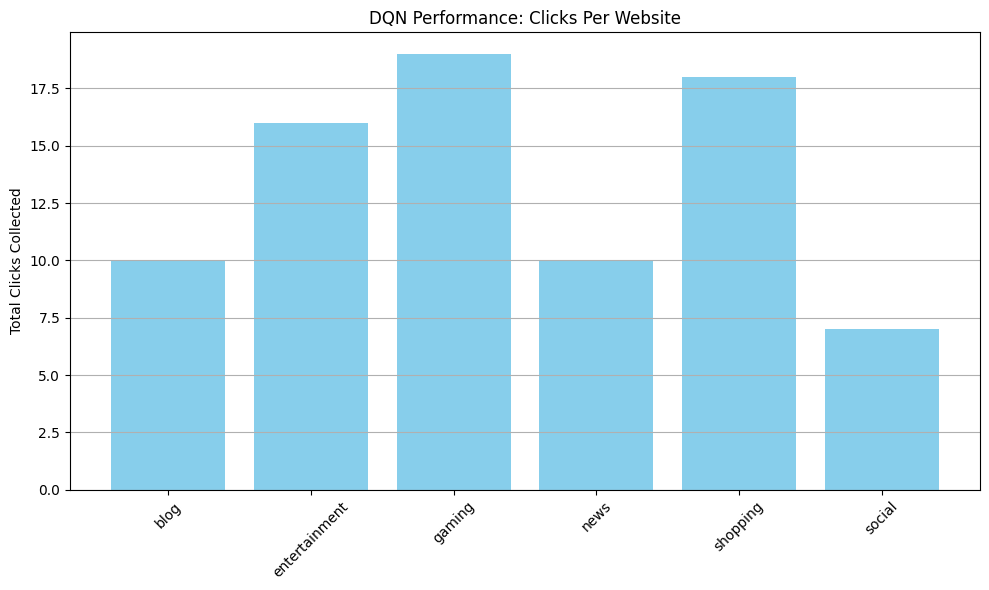

In [ ]:
# Plot Clicks Per Website
plt.figure(figsize=(10,6))
plt.bar(clicks_per_website.keys(), clicks_per_website.values(), color='skyblue')
plt.ylabel("Total Clicks Collected")
plt.title("DQN Performance: Clicks Per Website")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
# Display Optimal Bidding Strategy
optimal_bids_df = pd.DataFrame(optimal_bids).T
print("\nOptimal Bidding Strategy per Website:\n")
display(optimal_bids_df)


Optimal Bidding Strategy per Website:



,Average_Bid,Most_Frequent_Bid,Frequency
blog,3.85,3.0,199.0
entertainment,3.21,6.0,123.0
gaming,4.63,3.0,102.0
news,4.84,9.0,128.0
shopping,4.19,3.0,157.0
social,3.77,3.0,163.0


from matplotlib import pyplot as plt
optimal_bids_df['Average_Bid'].plot(kind='hist', bins=20, title='Average_Bid')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
optimal_bids_df['Most_Frequent_Bid'].plot(kind='hist', bins=20, title='Most_Frequent_Bid')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
optimal_bids_df['Frequency'].plot(kind='hist', bins=20, title='Frequency')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
optimal_bids_df.plot(kind='scatter', x='Average_Bid', y='Most_Frequent_Bid', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
optimal_bids_df.plot(kind='scatter', x='Most_Frequent_Bid', y='Frequency', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
optimal_bids_df['Average_Bid'].plot(kind='line', figsize=(8, 4), title='Average_Bid')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
optimal_bids_df['Most_Frequent_Bid'].plot(kind='line', figsize=(8, 4), title='Most_Frequent_Bid')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
optimal_bids_df['Frequency'].plot(kind='line', figsize=(8, 4), title='Frequency')
plt.gca().spines[['top', 'right']].set_visible(False)

bid higher on 'news' websites compared to 'blog' websites to get your ads seen and clicked on.

1. **Average Bid:**  This shows how much, on average, was offered in the bidding process.

2. **Most Frequent Bid:**  This tells you what the most common bid value was.

3. **Frequency:**  This indicates how active the bidding was in each category.

# User Centric

In [ ]:
#  User-defined total budget
user_budget = float(input("Enter your total advertising budget (e.g., 1000): "))

Enter your total advertising budget (e.g., 1000): 1000


In [ ]:
#  Calculate Optimal Allocation Based on Budget
budget_allocation = {}
spend_per_website = {}
clicks_per_website_budgeted = {}

In [ ]:
for website_id, website_name in enumerate(website_labels):
    print(f"\n Evaluating strategy for: {website_name}")

    env = AdBiddingEnv(state_vectors, website_id)
    model = DQN("MlpPolicy", env, verbose=0)

    #  Re-train for simplicity (or use the one from earlier)
    model.learn(total_timesteps=50000)

    obs = env.reset()
    done = False
    spent = 0
    clicks = 0
    bid_log = []

    while not done and spent < user_budget:
        action, _ = model.predict(obs)
        bid_amount = float(env.bid_values[action])
        obs, reward, done, _ = env.step(action)

        # Spend budget only if click occurs (reward > 0)
        if reward > 0:
            spent += bid_amount
            clicks += 1
            bid_log.append(bid_amount)

    budget_allocation[website_name] = round(spent, 2)
    spend_per_website[website_name] = bid_log
    clicks_per_website_budgeted[website_name] = clicks


 Evaluating strategy for: blog


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(



 Evaluating strategy for: entertainment


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(



 Evaluating strategy for: gaming


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(



 Evaluating strategy for: news


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(



 Evaluating strategy for: shopping


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(



 Evaluating strategy for: social


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


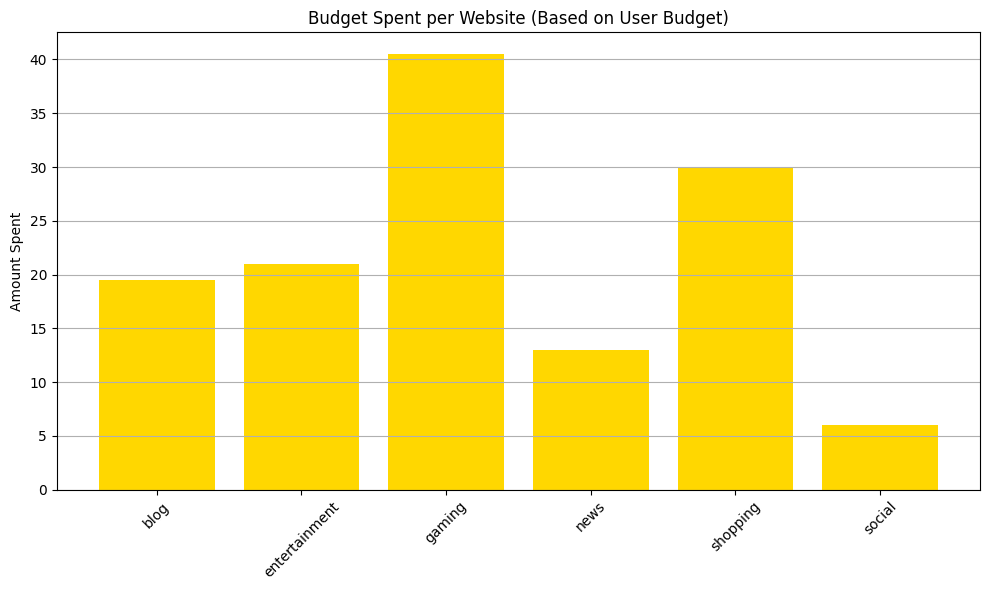

In [ ]:
# Plot Budget Allocation
plt.figure(figsize=(10, 6))
plt.bar(budget_allocation.keys(), budget_allocation.values(), color='gold')
plt.title("Budget Spent per Website (Based on User Budget)")
plt.ylabel("Amount Spent")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
# Show Summary Table
budget_summary = pd.DataFrame({
    "Amount_Spent": budget_allocation,
    "Clicks_Generated": clicks_per_website_budgeted,
    "Avg_Bid_Used": {k: round(np.mean(v), 2) if v else 0 for k, v in spend_per_website.items()}
})

In [ ]:
print("\n Bidding Summary Based on User Budget:")
display(budget_summary)


 Bidding Summary Based on User Budget:


,Amount_Spent,Clicks_Generated,Avg_Bid_Used
blog,19.5,7,2.79
entertainment,21.0,11,1.91
gaming,40.5,16,2.53
news,13.0,6,2.17
shopping,30.0,13,2.31
social,6.0,3,2.00


1. **Amount_Spent:** The total money spent on bids for each category.

2. **Clicks_Generated:** The number of clicks received from the ads in each category.

3. **Avg_Bid_Used:** The average bid amount used for each category.

helps evaluate how efficiently the budget was used to generate clicks across various website categories.

"**gaming**" gave the best results, generating 16 clicks.

In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=budget_summary)

https://docs.google.com/spreadsheets/d/1zfiEEItDXbOYEUmbrPi3S67c5GcWt_z6f4xs69b8KUI/edit#gid=0


/usr/local/lib/python3.11/dist-packages/google/colab/sheets.py:331: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  worksheet.update(location, data, **kwargs)


In [ ]:
# prompt: Using dataframe budget_summary: pie chart

import altair as alt

# Create a pie chart of the 'Amount_Spent' column
alt.Chart(budget_summary).mark_arc().encode(
    theta='Amount_Spent',
    color='Amount_Spent'  # Color the slices by 'Amount_Spent'
)


alt.Chart(...)